In [13]:
import datetime
import os

import astropy
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.visualization import ImageNormalize, SqrtStretch, PowerStretch, AsinhStretch

import sunpy
from sunpy.map import Map
from sunpy.map.header_helper import make_fitswcs_header
from sunpy.coordinates.frames import Helioprojective, HeliographicStonyhurst

import matplotlib as mpl
import matplotlib.pyplot as plt

from aiapy.calibrate import normalize_exposure, register, update_pointing

# Install via: pip install mlso-api-client
from mlso.api import client

Set the date/time and interval to search for KCor and AIA files within.

In [18]:
start_date = "2025-03-24T18:04:00"
time_interval = datetime.timedelta(minutes=1)
datetime_fmt = "%Y-%m-%dT%H:%M:%S"
end_date = (datetime.datetime.strptime(start_date, datetime_fmt) + time_interval).strftime(datetime_fmt)
print(f"{start_date}..{end_date}")

2025-03-24T18:04:00..2025-03-24T18:05:00


In [19]:
kcor_files = client.files("kcor", "pbavgenh", filters={"start-date": start_date, "end-date": end_date})
kcor_filename = kcor_files["files"][0]["filename"]
if os.path.exists(kcor_filename):
    print(f"found {kcor_filename}, using cached file...")
else:
    print(f"found {kcor_filename}, downloading...")
    client.authenticate("username@example.com")
    _ = client.download_file(kcor_files["files"][0], ".")

found 20250324_180453_kcor_l2_pb_avg_enhanced.fts.gz, using cached file...


In [20]:
with fits.open(kcor_filename) as hdu:
    pB = hdu[0].data
    kcor_header = hdu[0].header

In [21]:
kcor_map = Map(pB, kcor_header)

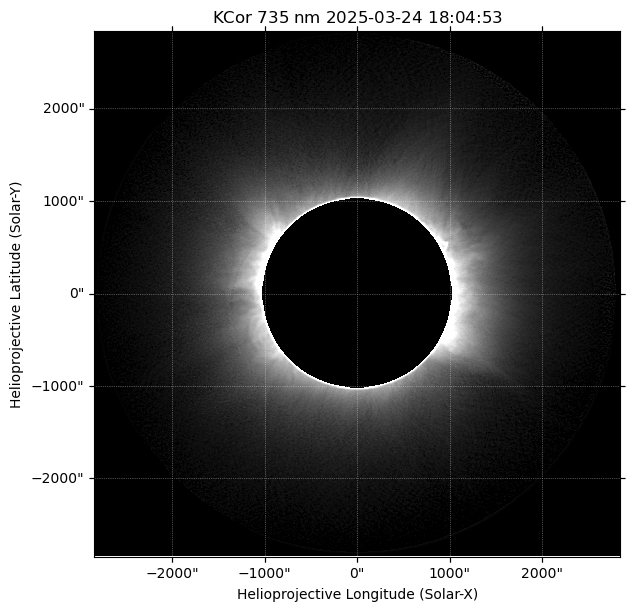

In [22]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)

kcor_norm = ImageNormalize(pB, stretch=PowerStretch(0.6), vmin=-7.0e-9, vmax=8.0e-7)

ax = fig.add_subplot(projection=kcor_map)
_ = kcor_map.plot(axes=ax, norm=kcor_norm)

In [23]:
from sunpy.net import Fido, attrs as a

aia_results = Fido.search(a.Time(start_date, end_date), a.Instrument("aia"), a.Wavelength(193 * u.angstrom))
aia_results.show()

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,fileid
,,,,Angstrom,,,,,,,Mibyte,
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64,str24
2025-03-24 18:04:04.000,2025-03-24 18:04:05.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:193:1521914683
2025-03-24 18:04:16.000,2025-03-24 18:04:17.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:193:1521914695
2025-03-24 18:04:28.000,2025-03-24 18:04:29.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:193:1521914707
2025-03-24 18:04:40.000,2025-03-24 18:04:41.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:193:1521914719
2025-03-24 18:04:52.000,2025-03-24 18:04:53.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:193:1521914731


In [24]:
downloaded_files = Fido.fetch(aia_results[0, 0], overwrite=False)
if len(downloaded_files) == 0:
    print("Download failed")
else:
    aia_filename = downloaded_files[0]
    aia_map = Map(aia_filename)
    aia_map.meta["rsun_ref"] = kcor_header["rsun_ref"]
    aia_map = register(update_pointing(aia_map))

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

2025-10-27 14:39:36 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=193_1521914683-1521914683 failed to download with exception
Timeout on reading data from socket


1/0 files failed to download. Please check `.errors` for details
Download failed


In [22]:
aia_map_reproject = aia_map.reproject_to(WCS(kcor_header))

2025-10-27 11:50:51 - astropy - WARNING: FITSFixedWarning: 'datfix' made the change 'Invalid parameter values: MJD-END and DATE-END are inconsistent'.


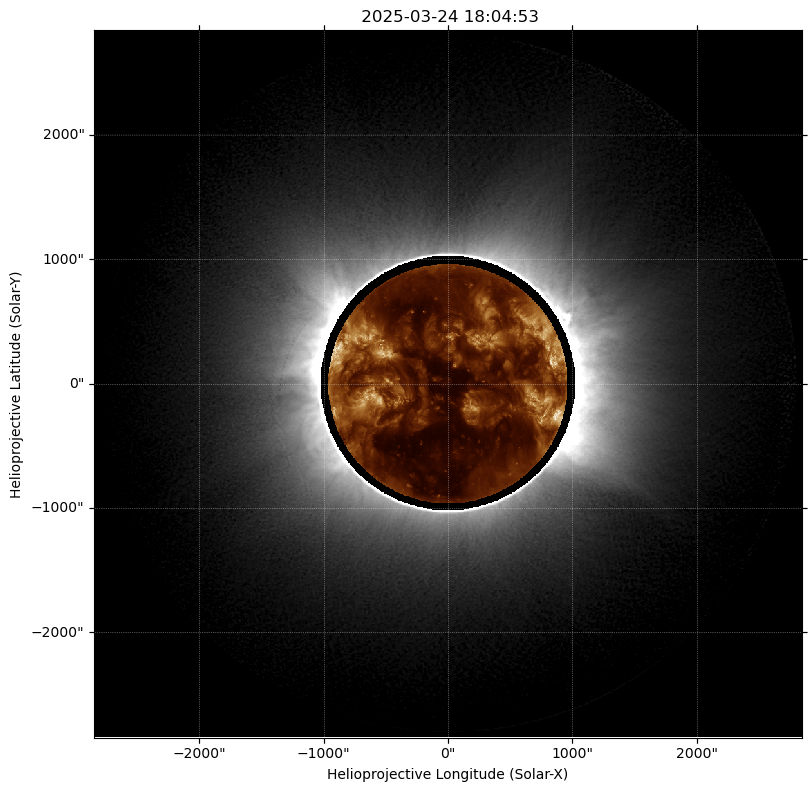

In [23]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)

norm_aia = ImageNormalize(aia_map_reproject.data, stretch=AsinhStretch(), vmin=0)

ax = fig.add_subplot(projection=kcor_map)
kcor_map.plot(axes=ax, norm=kcor_norm)
_ = aia_map_reproject.plot(axes=ax, cmap='sdoaia193', norm=norm_aia, autoalign=True)